In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
# Load the data
df = pd.read_csv('data/father_son.tsv', sep='\t')
df

,Father,Son
0,65.0,59.8
1,63.3,63.2
2,65.0,63.3
3,65.8,62.8
4,61.1,64.3
...,...,...
1073,67.0,70.8
1074,71.3,68.3
1075,71.8,69.3
1076,70.7,69.3


<AxesSubplot:xlabel='Father', ylabel='Son'>

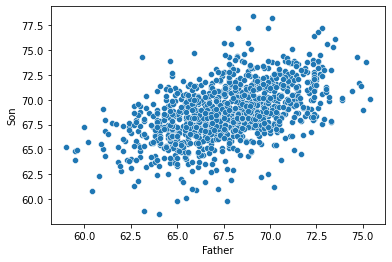

In [4]:
# scatterplot of the data
sns.scatterplot(x='Father', y='Son', data=df)

# How to predict the height of a son? 

simple idea: given a new father
* consider fathers with heights similar to the new father
* predict the average of the heights of their sons

In [5]:
new_father = 70
similar_fathers = df[np.abs(df['Father'] - new_father) < .5]
similar_fathers

,Father,Son
49,69.6,69.0
68,69.6,66.8
69,70.4,66.7
70,70.0,66.9
99,69.6,68.1
...,...,...
1045,70.3,72.2
1046,70.2,72.6
1054,70.4,73.7
1065,69.9,77.2


In [6]:
# predict the mean of sons' heights among these similar fathers 
similar_fathers['Son'].mean()

69.83714285714285

<AxesSubplot:xlabel='Father', ylabel='Son'>

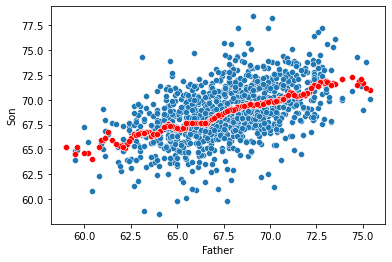

In [7]:
# let's write a function to do this prediction
def predict_son_height(father_height):
    similar_fathers = df[np.abs(df['Father'] - father_height) < .5]
    return similar_fathers['Son'].mean()

# apply the function to predict heights of all fathers in the dataset
df['Predicted Son'] = df['Father'].apply(predict_son_height)

# plot the predictions
sns.scatterplot(x='Father', y='Son', data=df)
sns.scatterplot(x='Father', y='Predicted Son', data=df, color='red')

...it's close to linear! 

question: how could we improve our predictions?

# Regression

* estimate a linear relation between values of y and values of x
* predict using linear function

In [13]:
# fit a least squares model
x = df['Father']
X = sm.add_constant(x)
y = df['Son']
model = sm.OLS(y, X).fit()
yhat = model.predict(X) # make the predictions by the model
df['Linear Son'] = yhat
df

,Father,Son,Predicted Son,Linear Son
0,65.0,59.8,67.178261,67.303185
1,63.3,63.2,66.711429,66.429375
2,65.0,63.3,67.178261,67.303185
3,65.8,62.8,67.630769,67.714390
4,61.1,64.3,66.133333,65.298562
...,...,...,...,...
1073,67.0,70.8,68.152033,68.331197
1074,71.3,68.3,70.513793,70.541422
1075,71.8,69.3,70.523810,70.798425
1076,70.7,69.3,70.061765,70.233019


<AxesSubplot:xlabel='Father', ylabel='Son'>

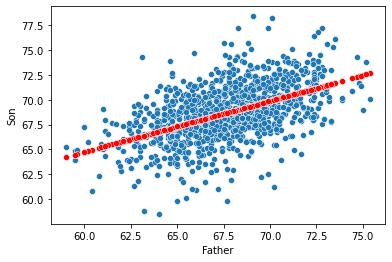

In [14]:
# plot the predictions
sns.scatterplot(x='Father', y='Son', data=df)
sns.scatterplot(x='Father', y='Linear Son', data=df, color='red')

<AxesSubplot:xlabel='Father', ylabel='Son'>

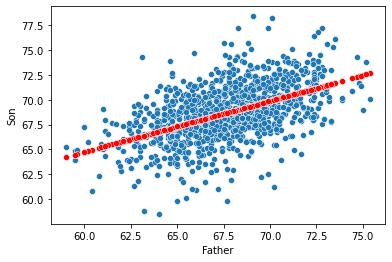

In [56]:
# alternative syntax: we can fit the model using a formula
model = smf.ols('Son ~ Father', data=df).fit()
yhat = model.predict(X) # make the predictions by the model

# plot the predictions
sns.scatterplot(x='Father', y='Son', data=df)
sns.scatterplot(x='Father', y=yhat, data=df, color='red')

# Understanding coefficients

In [20]:
# get the model coefficients 
model.params

const     33.892801
Father     0.514006
dtype: float64

In [22]:
# this means that (rounding) (heights in inches)
def predict_son_height(father_height):
    predicted_son_height = 34 + 0.5 * father_height
    return predicted_son_height

## Poll

Using the formula
$$ \hat y = 34 + 0.5 x$$

If the father is 70 inches tall, we predict the son will be how tall?

In [24]:
# predict_son_height(70)

# Regression line vs SD line

* both cross the point of averages
* but the regression line is shallower 
* the slope of the regression line is the product of the slope of the SD line and the correlation

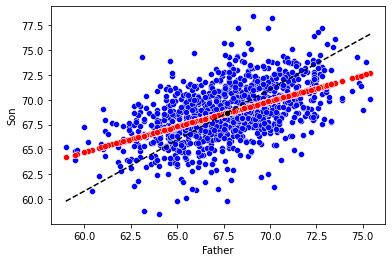

In [17]:
# plot the predictions
sns.scatterplot(x='Father', y='Son', data=df, color='blue')
sns.scatterplot(x='Father', y='Linear Son', data=df, color='red')

# plot the point of averages
avg_father = df['Father'].mean()
avg_son = df['Son'].mean()
sns.scatterplot(x=[avg_father], y=[avg_son], color='black')

# plot the SD line
std_father = df['Father'].std()
std_son = df['Son'].std()

# plot a line through the point (avg_father, avg_son) with slope std_son/std_father
x = np.linspace(df['Father'].min(), df['Father'].max(), 100)
y = avg_son + (x - avg_father) * std_son / std_father
plt.plot(x, y, color='black', linestyle='--')

# Assumptions of maximum likelihood model

* are the residuals normal?
* are the residuals iid?

<AxesSubplot:ylabel='Count'>

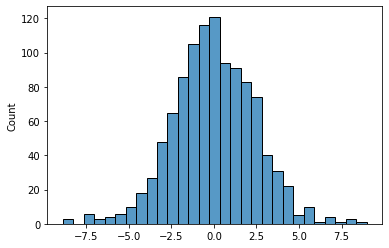

In [25]:
# check normality of residuals
r = model.resid
sns.histplot(r)

Text(0, 0.5, 'Residuals')

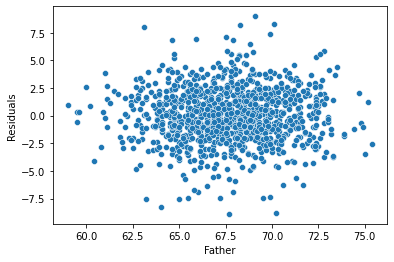

In [34]:
# check that residuals are iid 
sns.scatterplot(x='Father', y=r, data=df)
plt.ylabel('Residuals')

Text(0, 0.5, 'Residuals')

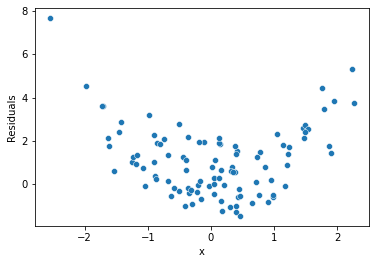

In [38]:
# example of non-iid residuals
np.random.seed(0)
n = 100
x = np.random.randn(n)
y = x**2 + np.random.randn(n)

# fit a least squares model
model = sm.OLS(y, x).fit()

# plot the residuals
sns.scatterplot(x=x, y=model.resid)
plt.xlabel('x')
plt.ylabel('Residuals')

<AxesSubplot:ylabel='Count'>

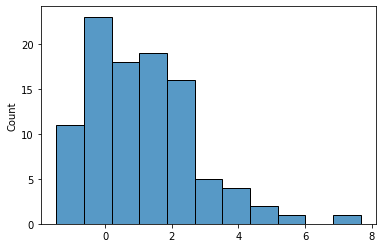

In [39]:
# example of non-normal residuals
sns.histplot(model.resid)

# Confidence intervals and prediction intervals

In [46]:
model = sm.OLS('Son', 'Father', data=df).fit()
CI = model.get_prediction().summary_frame(alpha=0.05)
CI


ValueError: unrecognized data structures: <class 'str'> / <class 'str'>

ValueError: x and y must have same first dimension, but have shapes (1078,) and (100,)

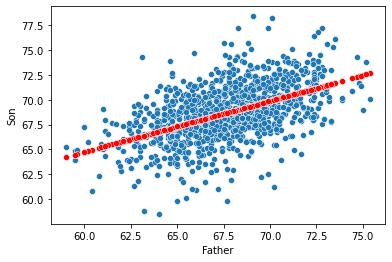

In [42]:
# plot predictions with confidence intervals
sns.scatterplot(x='Father', y='Son', data=df)
sns.scatterplot(x='Father', y='Linear Son', data=df, color='red')
plt.plot(df['Father'], CI['mean_ci_lower'], color='red', linestyle='--')
plt.plot(df['Father'], CI['mean_ci_upper'], color='red', linestyle='--')